In [52]:
import pandas as pd 
import numpy as np 
from sklearn import decomposition
from sklearn import preprocessing
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
from matplotlib.collections import LineCollection

# Creation de la base de donnée.

In [76]:
ratings=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/ratings.dat',sep="::",engine='python',names=['UserID','MovieID','Rating','Timestamp'])
users=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/users.dat',sep="::",engine='python',names=['UserID','Gender','Age','Occupation','Zip-code'])
movies=pd.read_table('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-1m/movies.dat',sep="::",engine='python',names=['MovieID','Title','Genres'])
links=pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/ml-25m/links.csv')

On va étudier chaque dataframe.

In [77]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


links donne les identifiants des films dans la base de données d'IMDb.  

In [78]:
links.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
movieId    62423 non-null int64
imdbId     62423 non-null int64
tmdbId     62316 non-null float64
dtypes: float64(1), int64(2)
memory usage: 1.4 MB


In [79]:
movies.tail()

,MovieID,Title,Genres
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama
3882,3952,"Contender, The (2000)",Drama|Thriller


In [80]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
MovieID    3883 non-null int64
Title      3883 non-null object
Genres     3883 non-null object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


On va réaliser une jointure afin d'avoir les identifiants de Movielens et d'IMDb pour chaque film.

In [81]:
print('avant la jointure il y a')
print(movies.shape[0]) 
print('films')
links['MovieID']=links['movieId']
del links['movieId']
#On renomme la colonne pour realiser la jointure. 
movies=movies.merge(links,on='MovieID',how='inner')
print('après la jointure il y a')
print(movies.shape[0]) 
print('films')

avant la jointure il y a
3883
films
après la jointure il y a
3849
films


On va rajouter une colonne rating au dataframe movie, qui donne la note moyenne du film.    
Pour cela on va utiliser les notes fournies par la base de données d'imdb. On a en effet plus de votes disponibles avec cette base de données qu'avec MovieLens.   
Pour accéder aux notes, on va ouvrir la base de données d'IMDb et utiliser la variable imdbId. 

In [82]:
title_rating = pd.read_csv('C:/Users/rapha/OneDrive/Documents/ENSAE Travail/2A/Info/title.ratings.tsv.tsv', sep="\t") #Base de données d'IMDb

In [83]:
title_rating.head()

,tconst,averageRating,numVotes
0,tt0000001,5.6,1663
1,tt0000002,6.1,206
2,tt0000003,6.5,1382
3,tt0000004,6.2,123
4,tt0000005,6.2,2170


In [84]:
title_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101502 entries, 0 to 1101501
Data columns (total 3 columns):
tconst           1101502 non-null object
averageRating    1101502 non-null float64
numVotes         1101502 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 25.2+ MB


On doit retirer les 'tt' dans la variable tconst. Les notes des utilisateurs movies sont sur 5, on va donc diviser par 2 la note IMDb. On change ensuite le nom de la variable tconst pour ensuite realiser une jointure sur la table movies.

In [85]:
title_rating['imdbId']=title_rating['tconst'].str[2:]
title_rating['imdbId']=title_rating.imdbId.astype(int)
movies=movies.merge(title_rating,on='imdbId',how='inner')
#On enlève ensuite les colonnes qui ne sont pas utiles
del movies['tmdbId']
del movies['tconst']
movies['rating']=movies['averageRating']/2 #On met la note IMDb sur 5
del movies['averageRating']
del movies['numVotes']
print('après la jointure il y a')
print(movies.shape[0]) 
print('films')

après la jointure il y a
3841
films


Une soixantaine de films a été supprimée de la base de données. On les retire de la base rating.   

In [86]:
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [87]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
UserID       1000209 non-null int64
MovieID      1000209 non-null int64
Rating       1000209 non-null int64
Timestamp    1000209 non-null int64
dtypes: int64(4)
memory usage: 30.5 MB


On va enlever les films qui n'ont pas de note dans la base de données ratings, ou qui ont été retirés lors de la jointure précédente.

In [88]:
print('avant la jointure il y a')
print(ratings.shape[0]) 
print('ratings')
index=movies['MovieID'].to_frame()
ratings=ratings.merge(index,on='MovieID',how='inner')
print('après la jointure il y a')
print(ratings.shape[0]) 
print('ratings')

avant la jointure il y a
1000209
ratings
après la jointure il y a
996723
ratings


On a perdu quelques notes, il y avait sans doute des doublons de movies qui ne correspondaient à aucun film.

On va modifier la variable timestamp, pour avoir l'année du rating.

In [89]:
import time
ratings['Timestamp'] = ratings['Timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,2000
1,2,1193,5,2000
2,12,1193,4,2000
3,15,1193,4,2000
4,17,1193,5,2000


In [90]:
ratings.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 996723 entries, 0 to 996722
Data columns (total 4 columns):
UserID       996723 non-null int64
MovieID      996723 non-null int64
Rating       996723 non-null int64
Timestamp    996723 non-null object
dtypes: int64(3), object(1)
memory usage: 38.0+ MB


In [91]:
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [92]:
users.info() #On regarde le type de chacune des variables

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
UserID        6040 non-null int64
Gender        6040 non-null object
Age           6040 non-null int64
Occupation    6040 non-null int64
Zip-code      6040 non-null object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


# Recherche de variables explicatives

On va étudier les différentes données, voir s'il y a des variables à normaliser, ...

In [93]:
print('on étudie les notes des utilisateurs')
print('la note minimale est:')
print(ratings['Rating'].min())
print('la note maximale est:')
print(ratings['Rating'].max())
print('la médiane est:')
print(ratings['Rating'].median())
print('la moyenne est:')
print(ratings['Rating'].mean())

on étudie les notes des utilisateurs
la note minimale est:
1
la note maximale est:
5
la médiane est:
4.0
la moyenne est:
3.5813972387513884


On va étudier l'influence du Genre sur la note d'un film. 

In [95]:
if movies['Genres'].isnull().sum()==0:
    print('Tous les films sont au moins dans une catégorie de genre')

Tous les films sont au moins dans une catégorie de genre


On regarde comment les genres pour les films sont distribués. Pour cela on realise un nuage de mots.
On a les catégories suivantes :
	* Action
	* Adventure
	* Animation
	* Children's
	* Comedy
	* Crime
	* Documentary
	* Drama
	* Fantasy
	* Film-Noir
	* Horror
	* Musical
	* Mystery
	* Romance
	* Sci-Fi
	* Thriller
	* War
	* Western

On va créer un dataframe df qui donne des dummy variables pour l'appartenance à un genre. On note df ce dataframe

In [96]:
Genre=['Action','Adventure','Animation',"Children's",'Comedy','Crime','Documentary','Drama','Fantasy',
       'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western']
df=movies['MovieID']
df = df.to_frame()
for i in range(0,len(Genre)):
    df[Genre[i]]=0
    df.loc[movies['Genres'].str.contains(Genre[i]), Genre[i]] = 1
df.head()

,MovieID,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


On va compter le nombre de films pour chaque catégorie.  
On peut ensuite faire un nuage de mots.

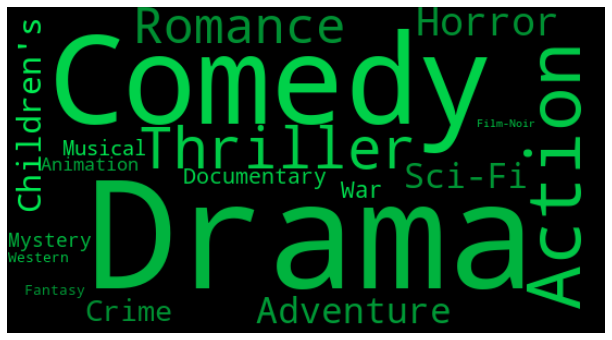

In [97]:
Occurences=[]
H=[]
for i in range (0,len(Genre)):
    H.append(df[Genre[i]].sum())
    Occurences.append([Genre[i],df[Genre[i]].sum()])
    
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)


#Finally, the result is shown as a wordcloud:
words = dict()
trunc_occurences = Occurences
for s in trunc_occurences:
    words[s[0]] = s[1]
tone = 100 # define the color of the words
f, ax = plt.subplots(figsize=(14, 6))
wordcloud = WordCloud(width=550,height=300, background_color='black', 
                      max_words=1628,relative_scaling=0.7,
                      color_func = random_color_func,
                      normalize_plurals=False)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Avec le nuage de mots on voit quels thèmes reviennent le plus parmi les films de la base de données.

On peut representer la même information à l'aide d'un graphique :

<BarContainer object of 18 artists>

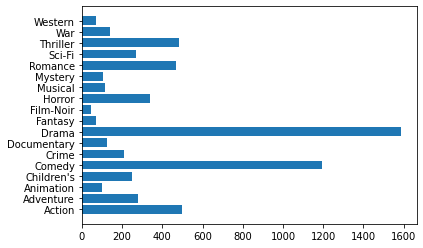

In [98]:
plt.barh(Genre,H)